In [1]:
# pip install showast # for displaying ast

In [2]:
# pip install graphviz # showast dependency

In [3]:
# pip install astunparse

In [4]:
import ast
import showast
import numpy as np
import astunparse

---

---

### Usseful Stuff

Aim: 
- At BinOps, count number of nested BinOps
- Use this value to help reverse the order of operations

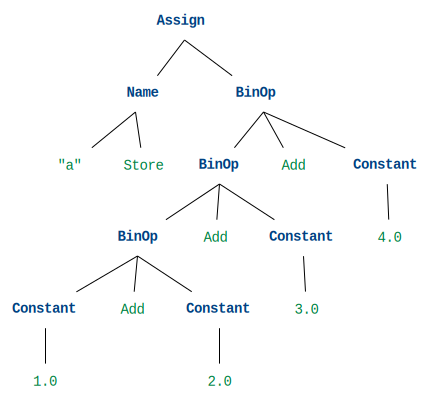

In [243]:
%%showast
a = 1. + 2. + 3. + 4.

In [320]:
source_ash = 'a = 1. + 2. + 3. + 4.' # to be manipulated
tree_ash = ast.parse(source_ash)

In [321]:
print(ast.dump(tree_ash, indent=4))

Module(
    body=[
        Assign(
            targets=[
                Name(id='a', ctx=Store())],
            value=BinOp(
                left=BinOp(
                    left=BinOp(
                        left=Constant(value=1.0),
                        op=Add(),
                        right=Constant(value=2.0)),
                    op=Add(),
                    right=Constant(value=3.0)),
                op=Add(),
                right=Constant(value=4.0)))],
    type_ignores=[])


In [322]:
# this visits BinOps instances within the tree

class BinOpCount(ast.NodeTransformer):
    # visit BinOps and count the number of nested BinOps
    def visit_BinOp(self, node):
        temp_node = node
        count = 0
        while str(type(temp_node.left)) == "<class 'ast.BinOp'>":  # check if child node is another BinOP
            count+=1
            temp_node = temp_node.left
        print(count)
        return node
    
# Q: how to output count variable without printing? As is, the module itself is all that's returned

In [323]:
vis_count = BinOpCount()
count = vis_count.visit(tree_ash)

2


In [324]:
count

In [325]:
home_node = tree_ash.body[0].value  # initialise
node = home_node

In [326]:
tree_ash.body[0].value

In [327]:
print(astunparse.unparse(home_node))

(((1.0 + 2.0) + 3.0) + 4.0)



In [328]:
lim = 2  # this value should be obtained automatically from BinOpCount

for i in range(lim):  # this will be incorporated into a method
    temp = node.right
    node.right = node.left.right
    node.left.right = temp
    node = node.left
    if i==lim-1:
        temp = node.left
        node.left = home_node.right
        home_node.right = temp

In [329]:
print(astunparse.unparse(tree_ash.body[0].value)) # reversed

(((3.0 + 4.0) + 2.0) + 1.0)



To run again cells must be executed starting from where the source is defined

---
---

### Messy Exploratory Stuff

In [236]:
source_code = '1.+2.+3.'
tree = ast.parse(source_code)

In [237]:
# print tree
ast.dump(tree)

'Module(body=[Expr(value=BinOp(left=BinOp(left=Constant(value=1.0), op=Add(), right=Constant(value=2.0)), op=Add(), right=Constant(value=3.0)))], type_ignores=[])'

In [238]:
print(astunparse.unparse(tree.body[0].value.left.left))

1.0



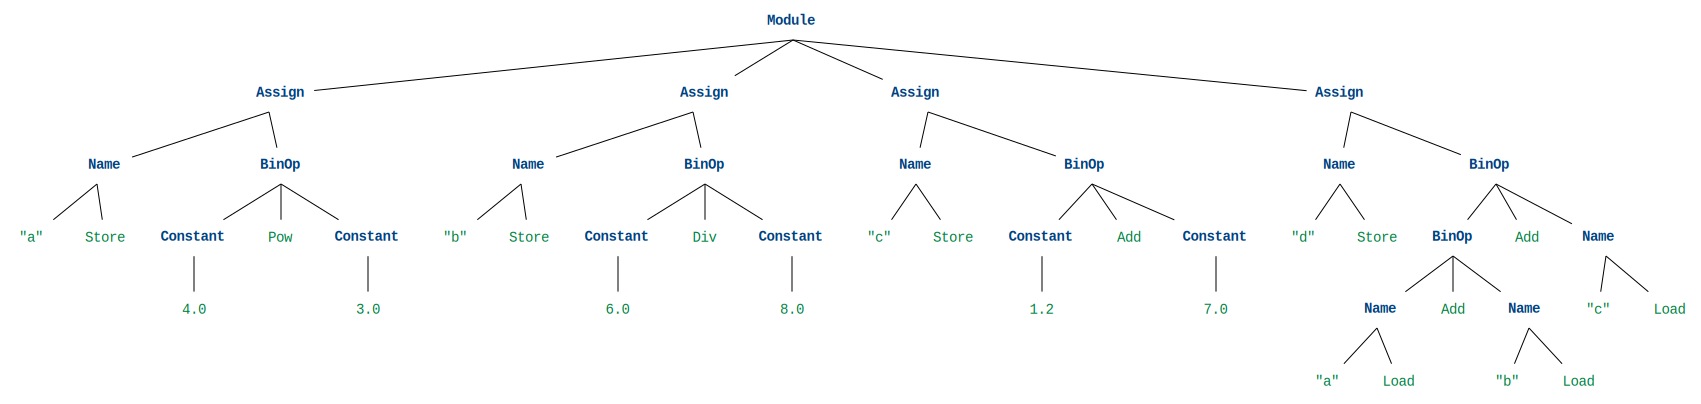

In [61]:
%%showast

a = 4.**3.
b = 6./8.
c = 1.2 + 7.

d = a + b + c

In [28]:
source_oak = """
a = 4.**3.
b = 6./8.
c = 1.2 + 7.
d = a + b + c
"""

In [29]:
tree_oak = ast.parse(source_oak)

In [12]:
for node in ast.walk(tree_oak):
    print(node.__class__.__name__)

Module
Assign
Assign
Assign
Assign
Name
BinOp
Name
BinOp
Name
BinOp
Name
BinOp
Store
Constant
Pow
Constant
Store
Constant
Div
Constant
Store
Constant
Add
Constant
Store
BinOp
Add
Name
Name
Add
Name
Load
Load
Load


In [13]:
for name, value in ast.iter_fields(tree_oak):
    print(name, value)

body [<ast.Assign object at 0x7f65def7fb80>, <ast.Assign object at 0x7f65defa0850>, <ast.Assign object at 0x7f65def13d00>, <ast.Assign object at 0x7f65def13df0>]
type_ignores []


In [14]:
for node in ast.iter_child_nodes(tree_oak):
    print(node.__class__.__name__)

Assign
Assign
Assign
Assign


In [73]:
class BinOpVisitor(ast.NodeVisitor):
    def visit_BinOp(self, node):
        print(f"found BinOp at line: {node.lineno}, {node.col_offset}, {node.end_lineno}, {node.end_col_offset}")
        self.generic_visit(node)

In [17]:
print(ast.dump(tree_oak, indent=4))

Module(
    body=[
        Assign(
            targets=[
                Name(id='a', ctx=Store())],
            value=BinOp(
                left=Constant(value=4.0),
                op=Pow(),
                right=Constant(value=3.0))),
        Assign(
            targets=[
                Name(id='b', ctx=Store())],
            value=BinOp(
                left=Constant(value=6.0),
                op=Div(),
                right=Constant(value=8.0))),
        Assign(
            targets=[
                Name(id='c', ctx=Store())],
            value=BinOp(
                left=Constant(value=1.2),
                op=Add(),
                right=Constant(value=7.0))),
        Assign(
            targets=[
                Name(id='d', ctx=Store())],
            value=BinOp(
                left=BinOp(
                    left=Name(id='a', ctx=Load()),
                    op=Add(),
                    right=Name(id='b', ctx=Load())),
                op=Add(),
                right=Name

In [18]:
vis = BinOpVisitor()
vis.visit(tree_oak)

found BinOp at line: 2
found BinOp at line: 3
found BinOp at line: 4
found BinOp at line: 5
found BinOp at line: 5


In [19]:
import random

class ConstantTransformer(ast.NodeTransformer):
    def visit_Constant(self, node):
        new_value = random.randint(-10,10)
        new_node = ast.Constant(new_value)
        print(f"replacing constant {node.value} -> {new_value} at {node.lineno}")
        return new_node

In [20]:
vis = ConstantTransformer()
new_tree = vis.visit(tree_oak)

replacing constant 4.0 -> -5 at 2
replacing constant 3.0 -> 3 at 2
replacing constant 6.0 -> -3 at 3
replacing constant 8.0 -> -6 at 3
replacing constant 1.2 -> 5 at 4
replacing constant 7.0 -> -4 at 4


In [64]:
import ast
import astunparse

class BinOpTransformer(ast.NodeTransformer):
    def visit_BinOp(self, node):
        print(ast.dump(node))
        print(str(type(node.op)))
        if str(type(node.op)) == "<class 'ast.Add'>":
            print('true')
            # save node location

        temp = node.right
        node.right = node.left
        node.left = temp
#         print(f"replacing constant {node.value} -> at {node.lineno}")
        return node

In [66]:
class BinOpProbing(ast.NodeTransformer):
    def visit_BinOp(self, node):
        print(ast.dump(node))
        print(str(type(node.op)))
        if str(type(node.op)) == "<class 'ast.Add'>":
            print('true')
            # save node location
            
        return node